# Prerequisites

```
conda installl -y numpy pandas scikit-learn matplotlib seaborn plotly ipykernel
pip install pandas_profiling
pip install git+https://github.com/WillKoehrsen/feature-selector
```

# Setup

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# activate output for values of multiple statements at once
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

# Load the data

In [2]:
df = pd.read_csv(os.getcwd()+"/data/day.csv")
df["dteday"] = pd.to_datetime(df["dteday"])
df = df.sort_values(by="dteday",ascending=True)
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


# Explorative data analysis

In [3]:
import pandas_profiling
pandas_profiling.ProfileReport(df)

Number of variables,16
Number of observations,731
Total Missing (%),0.0%
Total size in memory,97.1 KiB
Average record size in memory,136.0 B
Numeric,10
Categorical,0
Boolean,3
Date,1
Text (Unique),0
Rejected,2


# Time series plot

Text(0.5, 1.0, 'all data')

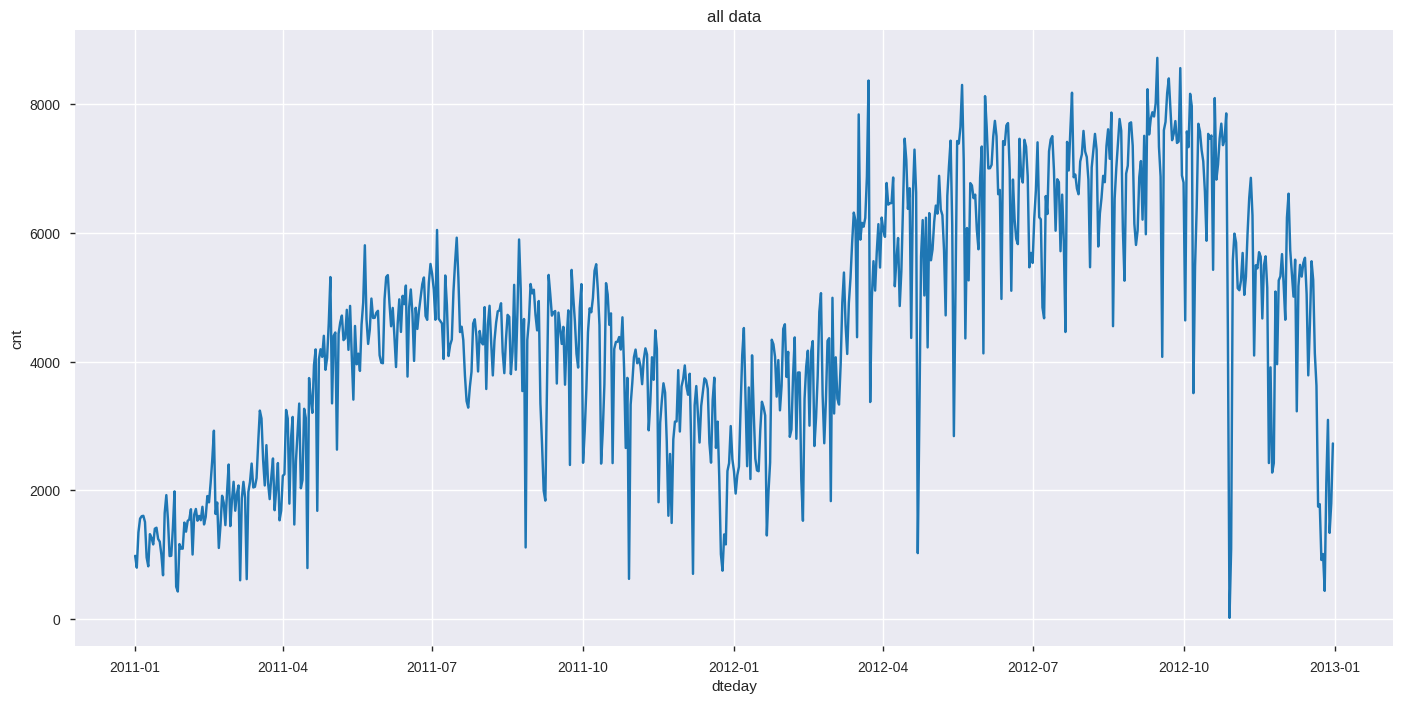

In [5]:
f, ax = plt.subplots(figsize=(17,8)) # Create a figure and one subplot
g=sns.lineplot(x="dteday", y="cnt", data=df) # Plot the response over time
plt.title("all data")
plt.show(g)

# Stationary

* 1st step in time series modeling: remove the effects of the trend or season
* Statistical modeling methods assume or require the time series to be stationary to be effective
* A stationary series is one where the mean of the series is no longer a function of time


## Stationary Time Series and Forecasting

Should you make your time series stationary?

Generally, yes.

If you have clear trend and seasonality in your time series, then model these components, remove them from observations, then train models on the residuals.

Statistical time series methods and even modern machine learning methods will benefit from the clearer signal in the data.

But…

We turn to machine learning methods when the classical methods fail. When we want more or better results. We cannot know how to best model unknown nonlinear relationships in time series data and some methods may result in better performance when working with non-stationary observations or some mixture of stationary and non-stationary views of the problem.

The suggestion here is to treat properties of a time series being stationary or not as another source of information that can be used in feature engineering and feature selection on your time series problem when using machine learning methods.

## How do we achieve stationarity?

There are two methods that can be applied to achieve stationarity, difference the data or linear regression.

https://www.kdnuggets.com/2018/03/time-series-dummies-3-step-process.html  
https://machinelearningmastery.com/time-series-data-stationary-python/

# Is our data stationary or non-stationary?

In [8]:
# to check, run the augmented Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df["cnt"].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.877448
p-value: 0.342743
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


**We fail to reject H0 => our data is non-stationary and should (most likely) be transformed!**

# Feature engineering

In [9]:
# add weekend column
df["weekend"] = 0
df.loc[df["weekday"].isin([5,6]), "weekend"] = 1

In [11]:
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'weekend'],
      dtype='object')

In [12]:
y = df["cnt"]
X = df.loc[:,['instant', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'weekend']]
#X = df.loc[:,['instant', 'yr', 'holiday', 'weekend', 'temp', 'hum', 'windspeed']]
#X = pd.concat([X,pd.get_dummies(df.weathersit, prefix="weathersit")],axis=1) # one-hot-encoded weathersit
#X = pd.concat([X,pd.get_dummies(df.mnth, prefix="mnth")],axis=1) # one-hot endoced month
X.shape
X.dtypes

(731, 12)

instant         int64
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
hum           float64
windspeed     float64
weekend         int64
dtype: object

# Feature Importance

* According to a gradient boosting machine (GBM) learning model
* tree-based boosting ensemble
* LightGBM library

Source: https://towardsdatascience.com/a-feature-selection-tool-for-machine-learning-in-python-b64dd23710f0

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[828]	valid_0's l2: 334465	valid_0's l2: 334465
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[301]	valid_0's l2: 272188	valid_0's l2: 272188
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[325]	valid_0's l2: 342243	valid_0's l2: 342243
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[442]	valid_0's l2: 315732	valid_0's l2: 315732
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[588]	valid_0's l2: 564101	valid_0's l2: 564101
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[86]	valid_0's l2: 359807	valid_0's l2: 359807
Training until validation scores don't improve for 100 rounds.
Early stopping, best iterati

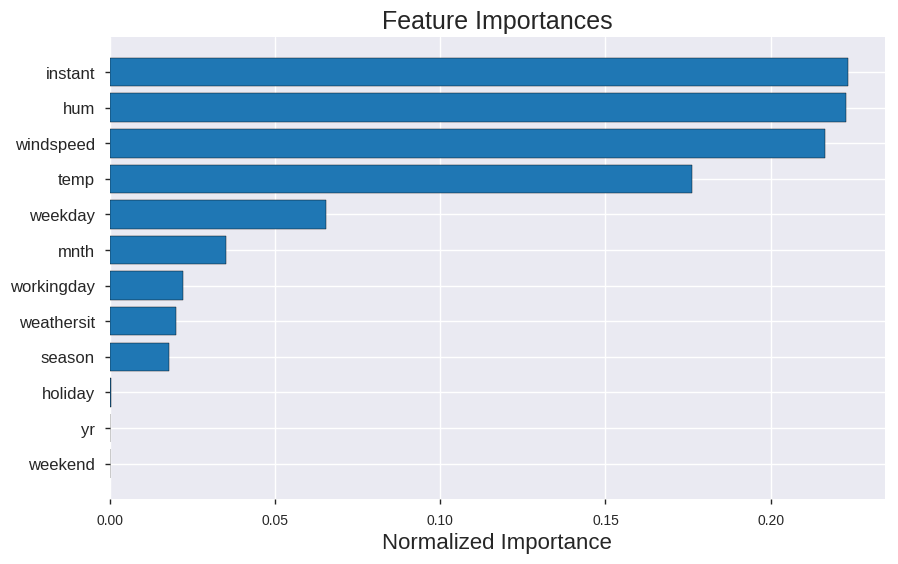

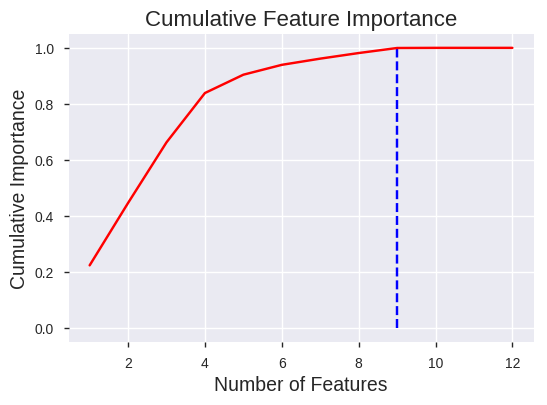

9 features required for 0.99 of cumulative importance


In [13]:
from feature_selector import FeatureSelector

# Features are in train and labels are in train_labels
fs = FeatureSelector(data = X, labels = y)

# Pass in the appropriate parameters
fs.identify_zero_importance(task = 'regression', 
                            eval_metric = 'mse', 
                            n_iterations = 10, 
                            early_stopping = True)

# plot the feature importances
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

# Train-Test-Split

In [12]:
# don't split random but take the first 18 month as train data and the last 6 month as test data
test_idx = df[(df["yr"]==1) & (df["mnth"]>5)].index

X_test=X.iloc[test_idx,]
y_test=y.iloc[test_idx,]

X_train=X.drop(test_idx)
y_train=y.drop(test_idx)

X_test.shape
X_train.shape
df.shape

(214, 9)

(517, 9)

(731, 17)

# Standardize the data

# it is best to apply ridge regression after standardizing the predictors!

COLUMNS_TO_STANDARDIZE = ['temp', 'hum', 'windspeed']

X_train_temp = X_train.loc[:,COLUMNS_TO_STANDARDIZE]
X_test_temp = X_test.loc[:,COLUMNS_TO_STANDARDIZE]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_temp)
X_train_temp = scaler.transform(X_train_temp)
X_test_temp = scaler.transform(X_test_temp)

# write back to DataFrame from the temp numpy arrays
i=0
for col in COLUMNS_TO_STANDARDIZE:
    X_train.loc[:,col] = X_train_temp[:,i]
    X_test.loc[:,col] = X_test_temp[:,i]
    i += 1

"Very often, the independent variables are centered and scaled in order to have variance 1."  
(Source: https://stats.stackexchange.com/questions/111017/question-about-standardizing-in-ridge-regression) 


# Ridge regression

In [13]:
from sklearn import linear_model
reg = linear_model.Ridge (alpha = .5)
reg.fit(X_train, y_train) 

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [14]:
reg.coef_
reg.intercept_

array([ 4.67381793e+01, -5.21032949e+02,  2.09241700e+00,  1.34649076e+03,
       -5.53315415e+02,  1.97868494e+02,  5.40566402e+03, -8.94181621e+02,
       -2.35908147e+03])

1815.1238921369945

In [15]:
from sklearn.metrics import mean_squared_error 
y_pred = reg.predict(X_test)
"{:,}".format(mean_squared_error(y_test, y_pred))

'1,545,154.1536335372'

In [16]:
from sklearn.metrics import r2_score
r2_score(y_train, reg.predict(X_train))

0.7668709160173334

## Plot test vs. pred

In [17]:
# prepare data for plotting (convert into long format)
test = pd.DataFrame({"dteday":df.iloc[test_idx,]["dteday"],
                         "cnt":y_test,
                         "type":"test"})
pred = pd.DataFrame({"dteday":df.iloc[test_idx,]["dteday"],
                         "cnt":y_pred,
                         "type":"pred"})
long_data=test.append(pred, ignore_index=True)

f, ax = plt.subplots(figsize=(13,8)) # Create a figure and one subplot
g=sns.lineplot(x="dteday", y="cnt", hue="type", data=long_data) # Plot the response over time
plt.title("test vs. pred")


from plotly.offline import init_notebook_mode, iplot
import plotly.tools as tls
init_notebook_mode(connected=True)

plotly_fig = tls.mpl_to_plotly( f ) # PRODUCED SOME WARNINGS
iplot(plotly_fig)

Text(0.5, 1.0, 'test vs. pred')

/home/arndt/anaconda3/envs/urban-tech/lib/python3.7/site-packages/plotly/matplotlylib/renderer.py:390: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/home/arndt/anaconda3/envs/urban-tech/lib/python3.7/site-packages/plotly/matplotlylib/renderer.py:390: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/home/arndt/anaconda3/envs/urban-tech/lib/python3.7/site-packages/plotly/matplotlylib/renderer.py:390: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/home/arndt/anaconda3/envs/urban-tech/lib/python3.7/site-packages/plotly/matplotlylib/renderer.py:487: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



# Ridge Regression - cross validated manually
Source: https://dziganto.github.io/cross-validation/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-with-Validation-and-Cross-Validation/

In [21]:
from sklearn.model_selection import cross_val_score

alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]

val_errors = []
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=.5, random_state=42)
    errors = np.sum(-cross_val_score(ridge, 
                                     X_train, 
                                     y=y_train, 
                                     scoring='neg_mean_squared_error', 
                                     cv=10, 
                                     n_jobs=-1))
    val_errors.append(np.sqrt(errors))

Let’s checkout the validation errors associated with each alpha.

In [22]:
# RMSE
print(val_errors)

[2894.9316292381927, 2894.9316292381927, 2894.9316292381927, 2894.9316292381927, 2894.9316292381927, 2894.9316292381927]


Which value of alpha gave us the smallest validation error?

In [23]:
print('best alpha: {}'.format(alphas[np.argmin(val_errors)]))

best alpha: 0.0001


# Plot Ridge coefficients as a function of the regularization
Source: http://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html#sphx-glr-auto-examples-linear-model-plot-ridge-path-py

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=0.011226677735108135, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.012603829296797275, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.01414991297434576, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.015885651294280528, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.017834308769319095, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.020022003718155844, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.02247805833548725, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.02523539170434766, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.02833096101839324, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.031806256927941194, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.03570785964900463, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.04008806328898465, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.04500557675700498, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.0505263106533568, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.05672426068491978, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.06368249944718586, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.07149428986597577, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.08026433522257174, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.09011018251665019, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.10116379797662076, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.11357333583431058, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.12750512407130135, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.14314589375234793, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.16070528182616392, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.18041864093920726, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.20255019392306675, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.22739657523579287, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.2552908068239518, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.2866067616948252, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.3217641750250737, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.3612342699709432, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.40554607358408296, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.455293507486695, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=0.5111433483440168, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.5738441648302396, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.6442363508721374, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.7232633896483537, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.8119844993184013, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=0.9115888299750823, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=1.0234114021054537, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=1.1489510001873098, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=1.2898902612533094, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=1.4481182276745346, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=1.625755666443795, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=1.8251834943190444, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=2.049074689815848, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=2.300430119772919, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=2.5826187606826774, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=2.899422853882878, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=3.2550885998350596, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=3.654383070957258, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=4.102658105827195, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=4.605922041145108, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=5.17092024289676, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=5.805225516094902, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=6.517339604882427, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=7.3168071434272, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=8.21434358491943, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=9.221978823334332, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=10.353218432956627, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=11.62322468679853, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=13.049019780144029, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=14.649713983072864, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=16.446761779946645, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=18.464249428955444, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=20.72921779595372, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=23.272024789604096, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=26.126752255633292, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=29.331662783900455, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=32.929712550971516, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=36.96912707195028, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=41.50404757850477, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=46.59525668664682, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=52.31099308056263, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=58.72786613189483, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=65.93188271333548, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=74.01959996915645, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=83.09941949353396, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=93.29304026284686, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=104.73708979594508, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=117.58495540521582, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=132.00884008314193, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=148.202070579886, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=166.38168860761309, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=186.79135990207848, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=209.7046401323235, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=235.42864143224202, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=264.30814869741084, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=296.73024081888724, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=333.1294787934677, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=373.99373024788014, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=419.8707084443914, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=471.3753134116729, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=529.1978735958447, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=594.113398496504, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=666.9919663030129, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=748.810385759003, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=840.6652885618333, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=943.7878277775391, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=1059.560179277617, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=1189.5340673703208, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=1335.4515629299, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=1499.268432786047, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=1683.1803533309583, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=1889.6523396912116, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=2121.451784910632, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=2381.6855519761607, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=2673.8416158399496, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=3001.835813575592, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=3370.0643292719315, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=3783.462617131933, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=4247.571552536902, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=4768.611697714475, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=5353.566677410729, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=6010.2767820703875, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=6747.5440531107, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=7575.25025877192, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=8504.489341802686, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=9547.716114208066, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=10718.913192051286, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=12033.778407775904, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=13509.935211980279, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=15167.168884709241, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=17027.691722259013, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=19116.440753857038, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=21461.41197858406, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=24094.03560239527, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=27049.59730463137, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=30367.711180354607, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=34092.850697468144, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=38274.94478516315, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=42970.04704320844, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=48241.08704165374, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=54158.71378079476, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=60802.24261649427, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=68260.71834272392, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=76634.10868007463, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=86034.64416684509, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=96588.32241158708, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=108436.59686896109, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=121738.27277396621, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=136671.63564620074, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=153436.84089300132, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=172258.59653987875, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=193389.1750455232, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=217111.79456945052, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=243744.41501222216, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=273643.9997074672, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=307211.2998861759, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=344896.22604057594, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=387203.8781812557, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=434701.31581250264, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=488025.15836544335, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=547890.1179593945, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=615098.5788580504, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=690551.352016233, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=775259.7488629464, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=870359.1361485166, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=977124.1535346502, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=1096985.7978923863, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=1231550.603292826, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=1382622.1737646593, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=1552225.357427048, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=1742633.3860096543, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=1956398.3435170648, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=2196385.372416551, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=2465811.075822604, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=2768286.6303920723, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=3107866.187782014, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=3489101.2134067807, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=3917101.4908092604, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=4397603.60930273, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=4937047.852839003, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=5542664.520663119, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=6222570.8367302315, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=6985879.7467852635, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=7842822.0613376815, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=8804883.581643483, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=9884959.046625586, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=11097524.964120744, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=12458833.642950082, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=13987131.026472416, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=15702901.247293774, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=17629141.180959515, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=19791668.678535573, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=22219468.609395284, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=24945081.352303166, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=28005038.94183637, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=31440354.715915002, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=35297073.02730657, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=39626886.387014784, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=44487828.311275944, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=49945051.1585514, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=56071699.382054694, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

Ridge(alpha=62949889.90221888, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=70671812.73927505, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=79340966.65797491, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=89073546.38610458, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=100000000.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

(316227766.01683795, 0.0031622776601683824)

Text(0.5, 0, 'alpha')

Text(0, 0.5, 'weights')

Text(0.5, 1.0, 'Ridge coefficients as a function of the regularization')

(316227766.01683795,
 0.0031622776601683824,
 -3209.830699407068,
 6037.632858348303)

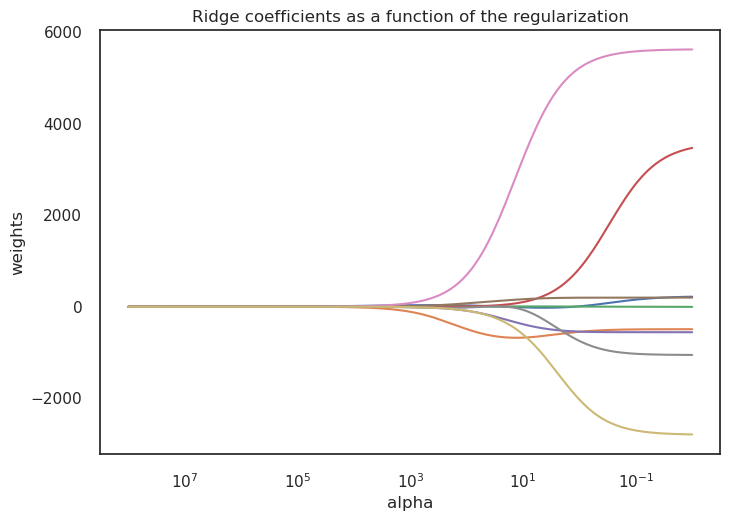

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

# #############################################################################
# Compute paths

n_alphas = 200
alphas = np.logspace(-2, 8, n_alphas)

coefs = []
for a in alphas:
    #ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

# #############################################################################
# Display results

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

# Further Soruces:
http://www.science.smith.edu/~jcrouser/SDS293/labs/lab10-py.html  
https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/  
https://becominghuman.ai/stats-models-vs-sklearn-for-linear-regression-f19df95ad99b  
https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit_regularized.html